# Imports

In [ ]:
import dataclasses, pickle, os, sys
from functools import partial
from pathlib import Path
import numpy as np
import jax, jax.numpy as jp, jax.random as rax, jax.tree_util as tu
import flax, flax.linen as nn, flax.serialization, flax.struct as struct
import matplotlib.pyplot as plt

stop = jax.lax.stop_gradient
deepmap = tu.tree_map

# Configuration

In [ ]:
@struct.dataclass
class Hp:
  outer_lr: float = 1e-4
  alpha: float = 2.
  outer_num_steps: int = 2001
  inner_num_steps: int = 100
  stride: int = 10
  batch_size: int = 128
  rho: float = 0.99
  game_discount: float = 0.96
  seed: int = 1
  explore_policy: str = "noisy_vhat"
  correction_version: int = 1  # agents follow grad(f+gamma V), V=f'+gamma V'

def draw_gamma(rng, shape=()):
  gamma = rax.uniform(rng, shape=shape)
  gamma = (1+jp.sin(2*np.pi*gamma))/2  # arcsin distribution; emphasize extreme values
  return gamma

# during training, we maintain "outer agents" -- agents that follow gradients of
# the model without any exploration and with fixed gamma. this allows us to
# monitor the performance while training.
OAGENT_GAMMAS = {s: float(f"0.{s}") for s in "90 95 99".split()}

# Architecture

In [ ]:
class VHat(nn.Module):
  size: int = 64
  quantiles: int = 32
  normalize: int = 1

  @nn.compact
  def __call__(self, agents, gamma, explore_rng=None, explore_level=0.):
    zpolicy = nn.sigmoid(agents)  # [player, features]
    zpolicy = nn.gelu(nn.Dense(self.size, name="embed")(zpolicy))
    zpolicy = nn.gelu(DenseNorm(self.size, normalize=self.normalize, name="zpolicy")(zpolicy))

    zgamma = nn.gelu(nn.Dense(self.size, name="zgamma")(gamma[:,None]))

    z = jp.concatenate([zpolicy, zgamma], axis=-1)
    z = nn.gelu(DenseNorm(self.size, normalize=self.normalize, name="mix_gamma")(z))
    for layer in range(2):
      z = ResidualBlock(name=f"Q{layer}", normalize=self.normalize)(z)
    z = jp.concatenate([z, z[::-1]], axis=-1)
    z = nn.gelu(DenseNorm(self.size, normalize=self.normalize, name="mix_oppt")(z))
    for layer in range(2):
      z = ResidualBlock(name=f"R{layer}", normalize=self.normalize)(z)
    z = nn.tanh(DenseNorm(self.size, normalize=self.normalize, name="zfinal")(z))

    if explore_rng is not None: # flip sign on units to vary vhat for use in explore
      keep_prob = 1 - explore_level/2
      mask = rax.bernoulli(rscope(explore_rng, "latent_mask"), p=keep_prob, shape=z.shape)
      z = jp.where(mask, z, -z)  # [player, features]
    return nn.Dense(self.quantiles, name="quantiles")(z) # [player, quantiles]

class DenseNorm(nn.Module):
  size: int
  normalize: int = 0

  @nn.compact
  def __call__(self, x):
    z = nn.Dense(self.size, kernel_init=nn.initializers.orthogonal(),
                 name="d", use_bias=not self.normalize)(x)
    if self.normalize:
      z = nn.LayerNorm(name="n")(z)
    return z

class ResidualBlock(nn.Module):
  normalize: int = 0

  @nn.compact
  def __call__(self, x):
    size = x.shape[-1]
    z = nn.gelu(DenseNorm(size, name="X", normalize=self.normalize)(x))
    y = nn.Dense(size, name=f"H")(z)
    gate = nn.sigmoid(self.param("G", nn.initializers.zeros, [z.shape[-1]]))
    return gate*x + (1-gate)*y

# Game definition

In [ ]:
def play_episode(agents, gamma):
  pi = nn.sigmoid(agents)
  assert pi.shape == (2,5)
  pi = pi.at[1].set(pi[1,(0,1,3,2,4)])  # swap player 2 perspective
  pi = jp.stack([1-pi,pi], axis=-1) # [player, state, action]
  p0 = jp.einsum("a,b->ab", pi[0,0], pi[1,0]).reshape([4]) # initial state distribution
  P = jp.einsum("sa,sb->sab", pi[0,1:], pi[1,1:]).reshape([4,4])  # transition matrix
  I = jp.eye(4)
  effective_state = (1-gamma)*p0@jp.linalg.inv(I-gamma*P)
  PAYOFFS = np.array([[-2,0,-3,-1],
                      [-2,-3,0,-1]]).T # [state, player]
  returns = effective_state@PAYOFFS
  return dict(returns=returns, effective_state=effective_state,
              epstats=dict(zip("DD DC CD CC".split(), effective_state)))

def init_agents(rng, batch_shape=()):
  return rax.normal(rng, shape=[*batch_shape,2,5])

# Utilities

In [ ]:
def take_about(k, xs):
  ys = [xs[i] for i in np.unique(np.round(np.linspace(0, len(xs) - 1, k)).astype("int"))]
  return ys
def eqzip(*xss):
  xss = list(map(list, xss))
  assert all(len(xs) == len(xss[0]) for xs in xss)
  return list(map(list, zip(*xss)))
def unzip2(xss):
  if not xss: return [], []
  return eqzip(*xss)
def rscope(rng, *path):
  # NOTE used to use seed = hash(path) but that is nondeterministic
  import zlib
  data = "/".join(map(str, path)).encode("ascii")
  seed = zlib.crc32(data)
  return rax.fold_in(rng, seed)
def params_rscope(rng, params):
  return flax.core.freeze(map_nested_dict(lambda path, param: rscope(rng, "/".join(map(str, path))),
                                          params))

def quantile_regression_loss(xs, ys):
  [n] = ys.shape
  mid = (jp.arange(n) + 0.5) / n  # quantile midpoints
  dq = ys[None, :] - xs[:, None]
  loss = jp.abs(mid[:, None] - (dq<0)) * huber(dq)
  return loss.sum() / n

def huber(delta, threshold=1):
  delta = jp.abs(delta)
  return jp.where(delta <= threshold,
                  delta ** 2 / 2,
                  threshold * delta - threshold ** 2 / 2)

def value_and_naive_gradients(f):
  def fn(agents):
    y, df = jax.vjp(f, agents)
    [dydx] = jax.vmap(df)(jp.eye(2,dtype="float32"))
    dx = jp.einsum("ii...->i...", dydx)
    return y, dx
  return fn
def naive_gradients(f):
  def fn(agents):
    y, dx = value_and_naive_gradients(f)(agents)
    return dx
  return fn

from collections import abc
def iterate_nested_dict(node):
  if not isinstance(node, abc.Mapping):
    yield (), node
  else:
    for key, child in node.items():
      for path, leaf in iterate_nested_dict(child):
        yield (key, *path), leaf
def map_nested_dict(fn, node, path=()):
  if not isinstance(node, abc.Mapping):
    return fn(path, node)
  return {
    key: map_nested_dict(fn, child, (*path, key))
    for key, child in node.items()
  }
def map_params_dict(fn, node):
  return flax.core.freeze(map_nested_dict(fn, node))

In [ ]:
@struct.dataclass
class VHatParameters:
  params: "Any"
  module: "Module" = struct.field(pytree_node=False)

  def __call__(self, agents, **kwargs):
    x = self.module.apply(dict(params=self.params), agents, **kwargs)
    return x.mean(axis=-1)

  def quantiles(self, agents, **kwargs):
    return self.module.apply(dict(params=self.params), agents, **kwargs)

  @classmethod
  def init(cls, module, rng):
    params = module.init(rng, init_agents(rax.PRNGKey(1)), gamma=jp.zeros([2], dtype="float32"))["params"]
    return cls(params, module)

  def rscope(self, rng):
    return self.replace(params=params_rscope(rng, self.params))
  def describe(self):  # show parameter shapes and sizes
    print("vhat params")
    for path, param in iterate_nested_dict(self.params):
      print("  ", "/".join(map(str, path)), param.shape, param.size)
    print("total vhat params", sum(param.size for param in tu.tree_leaves(self.params)))

@struct.dataclass
class AdamOptimizer:
  lr: float = struct.field(pytree_node=False, default=1e-3)
  eps: float = struct.field(pytree_node=False, default=1e-8)
  beta1: float = struct.field(pytree_node=False, default=0.9)
  beta2: float = struct.field(pytree_node=False, default=0.99)
  clip: "Any" = struct.field(pytree_node=False, default=None)
  decay: float = struct.field(pytree_node=False, default=0.01)
  moment1: "Any" = None
  moment2: "Any" = None
  n: int = 0

  @classmethod
  def make_for(cls, params, **hp):
    moment1 = deepmap(jp.zeros_like, params)
    moment2 = deepmap(jp.zeros_like, params)
    return cls(moment1=moment1, moment2=moment2, n=jp.array(0, dtype="int32"), **hp)

  def __call__(self, params, grad):
    if self.clip is not None:
      grad = deepmap(lambda dx: jp.clip(dx, -self.clip, +self.clip), grad)
    moment1 = deepmap(lambda m,dx: m + (1-self.beta1)*(dx-m), self.moment1, grad)
    moment2 = deepmap(lambda m,dx: m + (1-self.beta2)*(dx**2-m), self.moment2, grad)
    n = self.n + 1
    dbmoment1 = deepmap(lambda m: m / (1-self.beta1**n), moment1)
    dbmoment2 = deepmap(lambda m: m / (1-self.beta2**n), moment2)
    step = deepmap(lambda dm1,dm2,x: (self.lr*(dm1/(self.eps+dm2**0.5))
                                      -jp.abs(self.lr)*self.decay*x),
                   dbmoment1, dbmoment2, params)
    new_self = self.replace(moment1=moment1, moment2=moment2, n=n)
    return new_self, step

def apply_grads(optimizers, modules, grads):
  optimizers, steps = unzip2(opt(m, grad) for opt, m, grad in eqzip(optimizers, modules, grads))
  new_modules = [deepmap(lambda x, dx: x + dx, module, step)
                 for module, step in eqzip(modules, steps)]
  return optimizers, new_modules

# Training functions

In [ ]:
@struct.dataclass
class TrainState:
  step: int
  flat_step: int
  rng: "PRNGKey"
  vhat: "VHatParameters"
  target_vhat: "VHatParameters"
  optimizer: "AdamOptimizer"
  oagentss: "List[array(batch,2,5)]"

  @classmethod
  def make(cls, hp):
    rng = rax.PRNGKey(hp.seed)
    oagentss = cls._init_oagents(rscope(rng, "init_oagents"), hp)
    vhat = VHatParameters.init(VHat(size=128, normalize=1), rng=rng)
    optimizer = AdamOptimizer.make_for(vhat, lr=-hp.outer_lr)
    target_vhat = vhat.replace(params=deepmap(jp.array, vhat.params))
    state = cls(step=jp.array(0), flat_step=jp.array(0), rng=rscope(rng, "train"),
                vhat=vhat, target_vhat=target_vhat, optimizer=optimizer,
                oagentss=oagentss)
    return state

  def pop_rng(self):
    rng, elt = rax.split(self.rng)
    return self.replace(rng=rng), elt

  @classmethod
  def _init_oagents(cls, rng, hp):
    # for each OAGENT_GAMMAS, init a stacked batch of agents
    oagentss = [init_agents(rscope(rng, gammastr), [hp.batch_size])
                for gammastr, gamma in OAGENT_GAMMAS.items()]
    return oagentss
  def reset_oagents(self, rng, hp):
    oagentss = self._init_oagents(rng, hp)
    return self.replace(oagentss=oagentss)

def train(hp):
  def do_episode(agents, rng=None):
    episode = play_episode(agents, gamma=hp.game_discount)
    return episode["returns"], episode

  def prepare_vhat(vhat, gamma, context):
    vhat = partial(vhat, gamma=gamma)
    if not hp.correction_version: return vhat
    if context == "iagents": return vhat # just use vhat for explore
    def fn(agents):
      f, episode = do_episode(agents)
      vnext = vhat(agents)
      return f+gamma*vnext
    return fn

  @partial(jax.jit, donate_argnums=(1,))
  def update_iagents(ostate, istate, rng, gamma, explore_rng):
    @jax.vmap  # policy batch
    def fn(istate, rng, gamma, explore_rng):
      explore_level = 0.125
      vhat = dict(vhat=ostate.vhat,
                  target_vhat=ostate.target_vhat,
                  noisy_vhat=partial(ostate.vhat,
                                     explore_rng=rscope(explore_rng, "noisy_vhat"),
                                     explore_level=explore_level),
                  noisy_target_vhat=partial(ostate.target_vhat,
                                            explore_rng=rscope(explore_rng, "noisy_vhat"),
                                            explore_level=explore_level),
      )[hp.explore_policy]
      vhat = prepare_vhat(vhat, gamma, context="iagents")
      return do_inner_transitions(istate, vhat, rscope(rng, "inner_transition"), hp.stride)

    istates, epauxes = fn(istate, rax.split(rscope(rng, "inner_transition"), hp.batch_size),
                          gamma, rax.split(explore_rng, hp.batch_size))
    loss_fn = get_loss_fn(ostate, istates, [epaux["f"] for epaux in epauxes], gamma)
    loss, lossaux = loss_fn(ostate.vhat, rscope(rng, "model"))

    aux = dict(epstats=epauxes[0]["epstats"], f=epauxes[0]["f"],
               td=lossaux["td"], loss=loss, v=lossaux["v"])
    return istates[-1], aux

  @jax.jit
  def update_vhat(ostate, istate, rng, gamma):
    @jax.vmap  # policy batch
    def fn(istate, rng, gamma):
      vhat = prepare_vhat(ostate.vhat, gamma, context="vhat")
      istates, epauxes = do_inner_transitions(istate, vhat, rscope(rng, "inner_transition"), hp.stride)
      fs = [epaux["f"] for epaux in epauxes]
      return istates, epauxes, fs

    istates, epauxes, fs = fn(istate, rax.split(rscope(rng, "inner_transitions"), hp.batch_size), gamma)
    loss_fn = get_loss_fn(ostate, istates, fs, gamma)
    (loss, lossaux), grad = jax.value_and_grad(loss_fn, has_aux=True)(ostate.vhat, rscope(rng, "model"))
    new_optimizer, dvhat = ostate.optimizer(ostate.vhat, grad)
    new_vhat = deepmap(lambda x,dx:x+dx, ostate.vhat, dvhat)
    new_target_vhat = deepmap(lambda xbar,x: xbar+(1-hp.rho)*(x-xbar), ostate.target_vhat, new_vhat)

    new_ostate = ostate.replace(optimizer=new_optimizer, vhat=new_vhat, target_vhat=new_target_vhat)
    aux = dict(epstats=epauxes[0]["epstats"], f=epauxes[0]["f"],
               loss=loss, td=lossaux["td"], v=lossaux["v"],
               gradnorms=deepmap(lambda x: (x**2).mean(), grad))
    return new_ostate, aux

  def update_oagents(ostate, rng):
    new_oagentss = []; auxes = dict()
    for (gammastr, gamma), agents in eqzip(OAGENT_GAMMAS.items(), ostate.oagentss):
      new_agents, aux = _update_oagents(agents, ostate.target_vhat, rscope(rng, gammastr), gamma)
      new_oagentss.append(new_agents)
      auxes[gammastr] = aux
    return ostate.replace(oagentss=new_oagentss), auxes
  @partial(jax.jit, donate_argnums=(0))
  def _update_oagents(agents, vhat, rng, gamma):
    vhat = prepare_vhat(vhat, jp.full([2], gamma), context="oagents")
    @jax.vmap
    def fn(agents, rng):
      f, episode = do_episode(agents, rscope(rng, "episode"))
      v, grads = value_and_naive_gradients(vhat)(agents)
      agents = agents + hp.alpha * grads
      return agents, dict(episode=episode, epstats=episode["epstats"], f=f, v=v)
    return fn(agents, rax.split(rng, hp.batch_size))

  def do_inner_transitions(x, vhat, rng, n):
    xs = [x]; auxes = []
    for i in range(n):
      f, episode = do_episode(x)
      grads = naive_gradients(vhat)(x)
      x = x + hp.alpha * grads
      xs.append(x)
      auxes.append(dict(f=f, episode=episode, epstats=episode["epstats"]))
    f, episode = do_episode(x)
    auxes.append(dict(f=f, episode=episode, epstats=episode["epstats"]))
    return xs, auxes

  def get_loss_fn(ostate, istates, fs, gamma):
    def loss_fn_single(vhat, ostate, istates, fs, gamma):
      fs = fs[1:] if hp.correction_version else fs[:-1]

      T = len(istates)
      assert len(fs) + 1 == T
      rewards = jp.stack(fs) # [time,player]
      xs = deepmap(lambda *xs: jp.stack(xs), *[x for x in istates])  # agents with leading time axis
      vs = jax.vmap(partial(vhat.quantiles, gamma=gamma))(xs)  # [time,player,quantiles]
      tvs = jax.vmap(partial(ostate.target_vhat.quantiles, gamma=gamma))(xs)  # [time,player,quantiles]

      lamda = 0.9   # compute lamda-return by reverse scan
      gg = gamma[...,None]
      def body_fn(target, inputs):
        [r,tv] = inputs
        target = (1-gg)*r + gg*((1-lamda)*tv+lamda*target)
        return target,target
      _, targets = jax.lax.scan(body_fn, tvs[-1], [rewards[::-1,...,None],tvs[1:][::-1]])
      targets = targets[::-1]
      predictions = vs[:-1]

      loss = jax.vmap(jax.vmap(quantile_regression_loss))(predictions, targets) # across time,player
      td = (predictions-targets).mean(axis=-1) # across quantiles
      assert loss.shape == td.shape  # [time,player]

      return loss.mean(), dict(v=vs[0].mean(axis=-1), td=td[0])

    def loss_fn(vhat, rng):
      loss, aux = jax.vmap(partial(loss_fn_single, vhat, ostate))(istates, fs, gamma)
      return loss.mean(), aux
    return loss_fn

  def try_exploit(candidate, rng, nsteps=300): # train a naive agent against fixed candidate
    opponent = init_agents(rscope(rng, "init"))[0]
    assert opponent.shape == (5,)
    for step in range(nsteps):
      rng, steprng = rax.split(rng)
      opponent, f = _try_exploit_step(candidate, opponent, steprng)
    return dict(f=f, opponent=opponent)
  @jax.jit
  def _try_exploit_step(candidate, opponent, rng):
    def objective(opponent):
      agents = jp.stack([candidate, opponent])
      f, episode = do_episode(agents, rng)
      return f[1], dict(episode=episode, epstats=episode["epstats"], f=f)
    (_, aux), grad = jax.value_and_grad(objective, has_aux=True)(opponent)
    new_opponent = opponent + hp.alpha * grad
    return new_opponent, aux["f"]

  log = []
  ostate = TrainState.make(hp)
  while ostate.step < hp.outer_num_steps:
    ostate, rng = ostate.pop_rng()

    isteps = list(range(0, hp.inner_num_steps, hp.stride))
    init_irng, *irngs = rax.split(rscope(rng, "inner_init"), 1 + len(isteps))
    istate = init_agents(rscope(init_irng, "agents"), [hp.batch_size])
    gamma_explore = draw_gamma(rscope(init_irng, "gamma"), shape=[hp.batch_size,2])
    explore_rng = rscope(init_irng, "explore")

    for istep, irng in eqzip(isteps, irngs):
      # advance inner agents by hp.stride steps
      istate, iaux = update_iagents(ostate, istate, rscope(irng, "update_iagents"), gamma_explore, explore_rng=explore_rng)

      # advance outer agents by as many steps
      for _ in range(hp.stride):
        ostate, oauxes = update_oagents(ostate, rscope(rng, "oagents"))

      ostate, sample_aux = update_vhat(ostate, istate, rscope(irng, "train"),
                                       draw_gamma(rscope(irng, "gamma"), shape=[hp.batch_size,2]))

      ostate = ostate.replace(flat_step=ostate.flat_step + hp.stride)

    log.append(dict(loss=sample_aux["loss"], td=(sample_aux["td"] ** 2).mean()))

    ostate = ostate.replace(step=ostate.step + 1)
    if ostate.step % 100 == 0:
      print(ostate.step)
      # reset outer agents. first, print some information about the final outer agents
      for gammastr, oagents in eqzip(OAGENT_GAMMAS, ostate.oagentss):
        print("  outer agent stats", gammastr)
        oaux = oauxes[gammastr]
        exploit_aux = jax.vmap(try_exploit)(oagents[:,0], rax.split(rax.PRNGKey(1), hp.batch_size))
        print("    returns:", oaux["f"].mean(axis=0))
        print("    returns vs exploiter:", exploit_aux["f"].mean(axis=0))  # (agent2 is trained to exploit agent1)
        print("    expected state (DD DC CD CC):", np.array([oaux["epstats"][key].mean(axis=0) for key in "DD DC CD CC".split()]))
      ostate = ostate.reset_oagents(rscope(ostate.rng, "reset_oagents"), hp)

  return dict(ostate=ostate, log=log, hp=hp)

# Training

Training three seeds takes about 1.5 hours.

In [ ]:
runs = []
for seed in range(3):
  print("training seed", seed)
  runs.append(train(Hp(seed=seed)))

training seed 0
1
  outer agent stats 90
    returns: [-1.9755902 -1.9804583]
    returns vs exploiter: [-1.9990718 -1.9723415]
    expected state (DD DC CD CC): [0.95775896 0.02107706 0.01945446 0.00170893]
  outer agent stats 95
    returns: [-1.9719995 -1.970775 ]
    returns vs exploiter: [-1.9979146 -1.9625094]
    expected state (DD DC CD CC): [0.9485034  0.02268067 0.02308895 0.00572642]
  outer agent stats 99
    returns: [-1.9793838 -1.9775039]
    returns vs exploiter: [-2.000063 -1.970589]
    expected state (DD DC CD CC): [0.958412   0.01971945 0.020346   0.00152198]
100
  outer agent stats 90
    returns: [-1.9875742 -1.9875737]
    returns vs exploiter: [-1.9839821 -1.9887708]
    expected state (DD DC CD CC): [0.9835836  0.00399105 0.00399129 0.00843289]
  outer agent stats 95
    returns: [-1.9973261 -1.997615 ]
    returns vs exploiter: [-1.9779948 -1.9891487]
    expected state (DD DC CD CC): [9.9559975e-01 1.9197999e-03 1.8233911e-03 6.5736292e-04]
  outer agent stat

(0.0, 0.01)

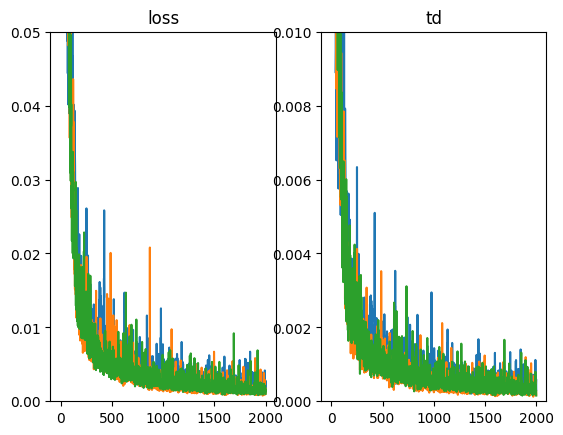

In [ ]:
fig, axes = plt.subplots(1,2, sharex=True)
for run in runs:
  seqs = deepmap(lambda *xs: jp.stack(xs), *run["log"])
  axes[0].plot(seqs["loss"])
  axes[1].plot(seqs["td"])
axes[0].set_title("loss")
axes[1].set_title("td")
axes[0].set_ylim((0,0.05))
axes[1].set_ylim((0,0.01))

# Analysis

For analysis we train a few batches of agents using the trained models. We train pairs of agents where both follow gradients of the model, then we hold one agent fixed and find the best response to it. Finally we also train pairs of agents where one agent follows gradients of the model and the other is naive, to demonstrate opponent shaping.

This takes about a minute to run.

In [ ]:
analysis_batch_size = 256

def train_agents(rng, vhat, gamma, hp):
  # both players follow vhat(.;gamma)
  agents = init_agents(rng, [analysis_batch_size])
  for step in range(500):
    agents = _train_agents_step(vhat, gamma, agents, hp.alpha, hp.game_discount)
  return agents
@jax.jit
@partial(jax.vmap, in_axes=(None,None,0,None,None))
def _train_agents_step(vhat, gamma, agents, alpha, game_discount):
  def fn(agents):
    v = vhat(agents, gamma=jp.full([2], gamma))
    # NOTE assuming hp.correction_version
    episode = play_episode(agents, gamma=game_discount)
    f = episode["returns"]
    return f+gamma*v
  v, grads = value_and_naive_gradients(fn)(agents)
  agents = agents + alpha * grads
  return agents

def train_responses(rng, hp, agents):
  # find best responses to both players
  responses = init_agents(rng, [analysis_batch_size])
  for step in range(500):
    responses = _train_responses_step(agents, responses, hp.alpha, hp.game_discount)
  return responses
@jax.jit
@partial(jax.vmap, in_axes=(0,0,None,None))
def _train_responses_step(agents, responses, alpha, game_discount):
  def fn(responses):
    episode0 = play_episode(jp.stack([responses[0], agents[0]]), gamma=game_discount)
    episode1 = play_episode(jp.stack([agents[1], responses[1]]), gamma=game_discount)
    return episode0["returns"][0] + episode1["returns"][1]
  v, grads = jax.value_and_grad(fn)(responses)
  responses = responses + alpha * grads
  return responses

def train_shaping(rng, vhat, gamma, hp):
  # let player two follow naive gradients; can we still attain cooperation?
  agents = init_agents(rng, [analysis_batch_size])
  for step in range(500):
    agents = _train_agents_step(vhat, jp.array([gamma, 0]), agents, hp.alpha, hp.game_discount)
  return agents

In [ ]:
def train_policies(run, gamma):
  rng = rax.PRNGKey(1)
  agents = train_agents(rscope(rng, "agents"), run["ostate"].target_vhat, gamma, run["hp"])
  responses = train_responses(rscope(rng, "responses"), run["hp"], agents)
  shapings = train_shaping(rscope(rng, "shaping"), run["ostate"].target_vhat, gamma, run["hp"])
  return dict(agents=agents,responses=responses,shapings=shapings)

def evaluate_policies(agents, responses, shapings):
  return dict(agents=play_episode(agents, gamma=0.96)["returns"],
              responses=play_episode(jp.stack([agents[0],responses[0]]), gamma=0.96)["returns"],
              shapings=play_episode(shapings, gamma=0.96)["returns"])

class Analysis:  # just a namespace
  gammastrs = "00 25 50 70 80 90 95 99 995 999".split()
  gammas = [float(f"0.{gammastr}") for gammastr in gammastrs]
  policies = dict()
  returns = []
  for gammastr, gamma in eqzip(gammastrs, gammas):
    things = []
    for run in runs:
      things.append(train_policies(run, gamma))
    things = {key: jp.stack(list(map(lambda t:t[key], things)), axis=0) # [seed,batch,2,5]
              for things in [things]
              for key in "agents responses shapings".split()}
    policies[gammastr] = things
    returns.append(jax.vmap(jax.vmap(evaluate_policies))(**policies[gammastr]))
  returns = deepmap(lambda *xs: jp.stack(xs), *returns) # [gamma,seed,batch,player]

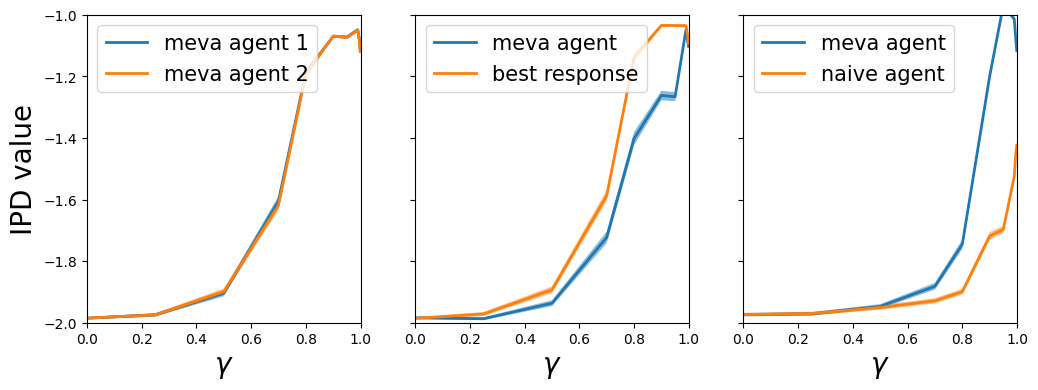

In [ ]:
def plot_returnpair(ax, ys, ylabel=False):
  ys = ys.reshape([len(Analysis.gammas), ys[0,:,:,0].size, 2])  # ravel seed/batch
  mu = ys.mean(axis=1)
  sem = ys.std(axis=1)/ys.shape[1]**0.5
  qs = np.stack([mu-sem, mu, mu+sem])
  ax.plot(Analysis.gammas, qs[1], linewidth=2)
  for i in range(2):
    ax.fill_between(Analysis.gammas, qs[0,:,i], qs[2,:,i], alpha=0.5)
  ax.set_xlabel("$\\gamma$", fontsize=20)
  if ylabel: ax.set_ylabel("IPD value", fontsize=20)
  ax.set_ylim((-2,-1)); ax.set_xlim((0,1))

fig, axes = plt.subplots(1,3,sharex=True, sharey=True, figsize=(12,4))
plot_returnpair(axes[0], Analysis.returns["agents"], ylabel=True)
axes[0].legend(["meva agent 1", "meva agent 2"], fontsize=15, loc="upper left")
plot_returnpair(axes[1], Analysis.returns["responses"])
axes[1].legend(["meva agent", "best response"], fontsize=15, loc="upper left")
plot_returnpair(axes[2], Analysis.returns["shapings"])
axes[2].legend(["meva agent", "naive agent"], fontsize=15, loc="upper left")

# Policy Histograms

For each run and gamma, we can plot a 2d histogram of the policy pairs. Along the y axis is the policy played by agent 1, along the x axis is the policy played by agent 2. The policies are binned into $2^5$ possibilities based on the argmax action for each of the five probabilities. 00000 is always-defect, 11111 is always-cooperate, 10101 is tit-for-tat.

In [ ]:
def plot_policy_histogram(zs, ax):
  [B,P,S] = zs.shape
  assert [P,S] == [2,5]
  heatmap = np.zeros([2]*P*S, dtype="int32")
  for b in range(B):
    binidx = (zs[b] > 0).astype("int32")
    binidx = binidx[:,::-1]  # reverse order so the ??101 strategies are grouped
    heatmap[(*binidx[0],*binidx[1])] += 1
  heatmap = heatmap.reshape([2**S]*P)
  plot_policy_heatmap(heatmap, ax, vmin=0, vmax=B)

def plot_vhat_heatmap(vhat, ax):
  ps = jp.stack([jp.array(p).reshape([2,5]) for p,_ in np.ndenumerate(np.zeros([2]*10))])
  zs = 5.0*(2*ps-1)
  vs = jax.vmap(vhat)(zs)
  [B,P,S] = zs.shape
  heatmap = np.zeros([2]*P*S, dtype="float32")
  for b in range(B):
    binidx = (zs[b] > 0).astype("int32")
    binidx = binidx[:,::-1]  # reverse order so the ??101 strategies are grouped
    heatmap[(*binidx[0],*binidx[1])] = vs[b,0]  # show only v0; v1 will be its transpose
  heatmap = heatmap.reshape([2**S]*P)
  plot_policy_heatmap(heatmap, ax)

def plot_policy_heatmap(heatmap, ax, vmin=None, vmax=None):
  ax.imshow(heatmap, cmap="magma_r", interpolation="none", vmin=vmin, vmax=vmax)
  ax.grid(True, which="major", axis="both", linestyle="-", color="k", alpha=0.25)
  ax.set_aspect("equal")
  ticklabels = []
  for binidx,_ in np.ndenumerate(np.zeros([2]*5)): # 32 tickmarks along both axes
    binidx = binidx[::-1]  # reverse order so the ??101 strategies are grouped
    ticklabels.append("".join(map(str, binidx)))
  ax.set_xticks(np.arange(len(ticklabels)))
  ax.set_yticks(np.arange(len(ticklabels)))
  ax.set_xticklabels(ticklabels)
  ax.set_yticklabels(ticklabels)
  ax.xaxis.set_ticks_position("top")
  ax.xaxis.set_label_position("top")
  # rotate xlabels to be vertical
  plt.setp(ax.get_xticklabels(), rotation=90, ha="left", va="center", rotation_mode="anchor")

Text(0.5, 0, 'naive agent')

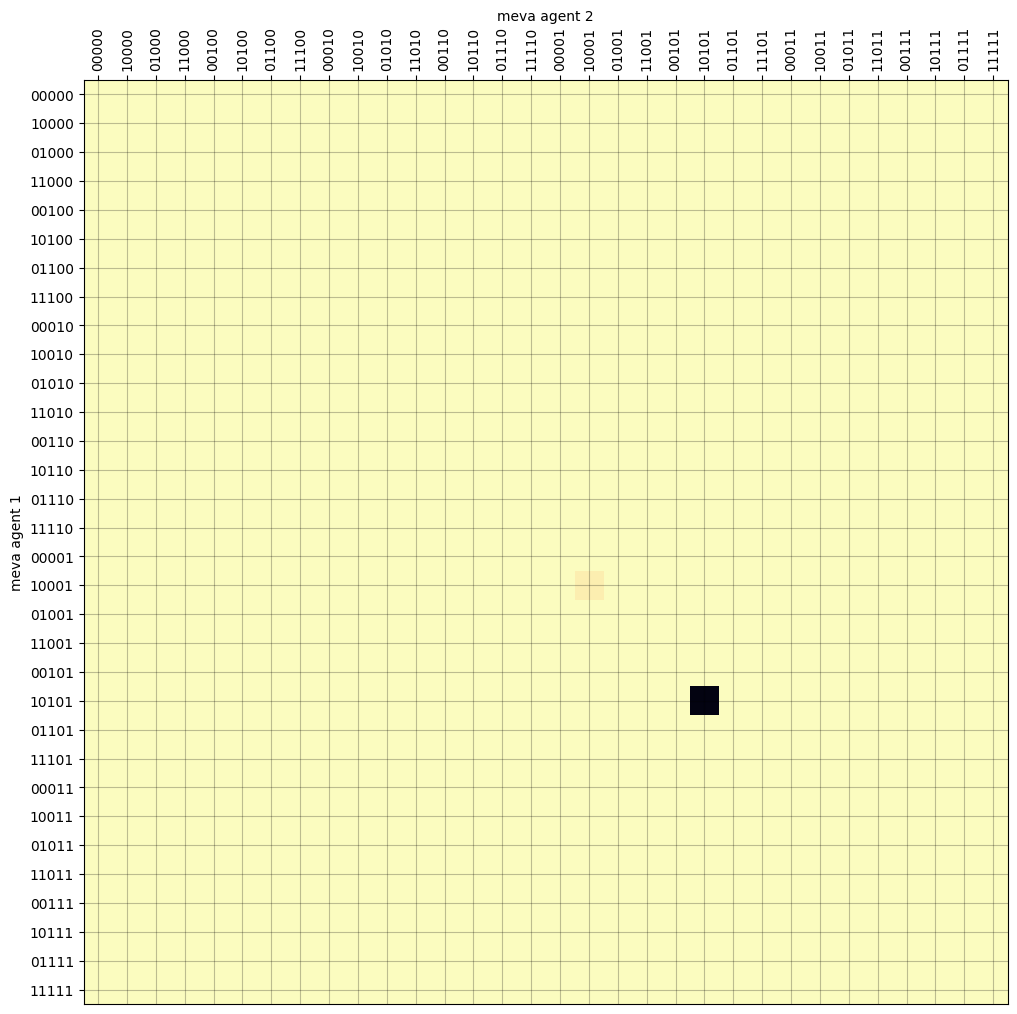

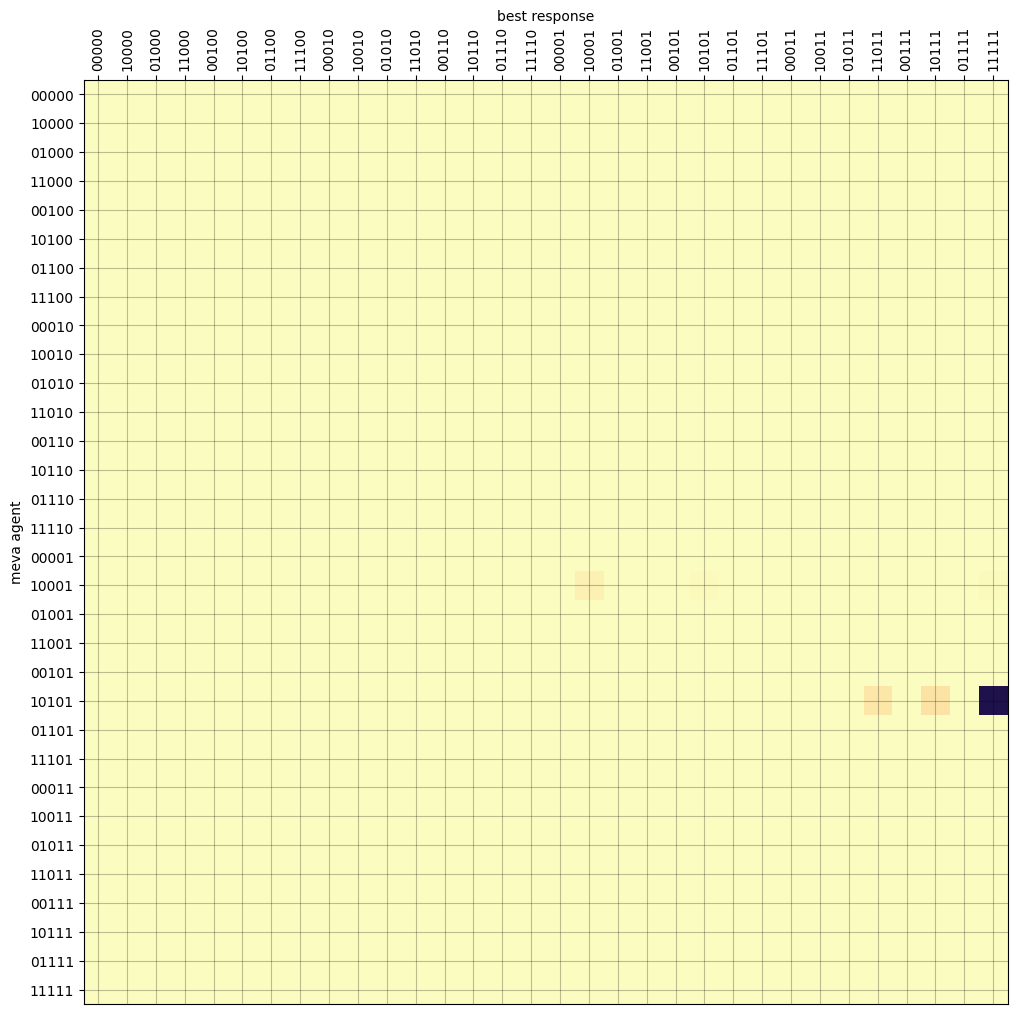

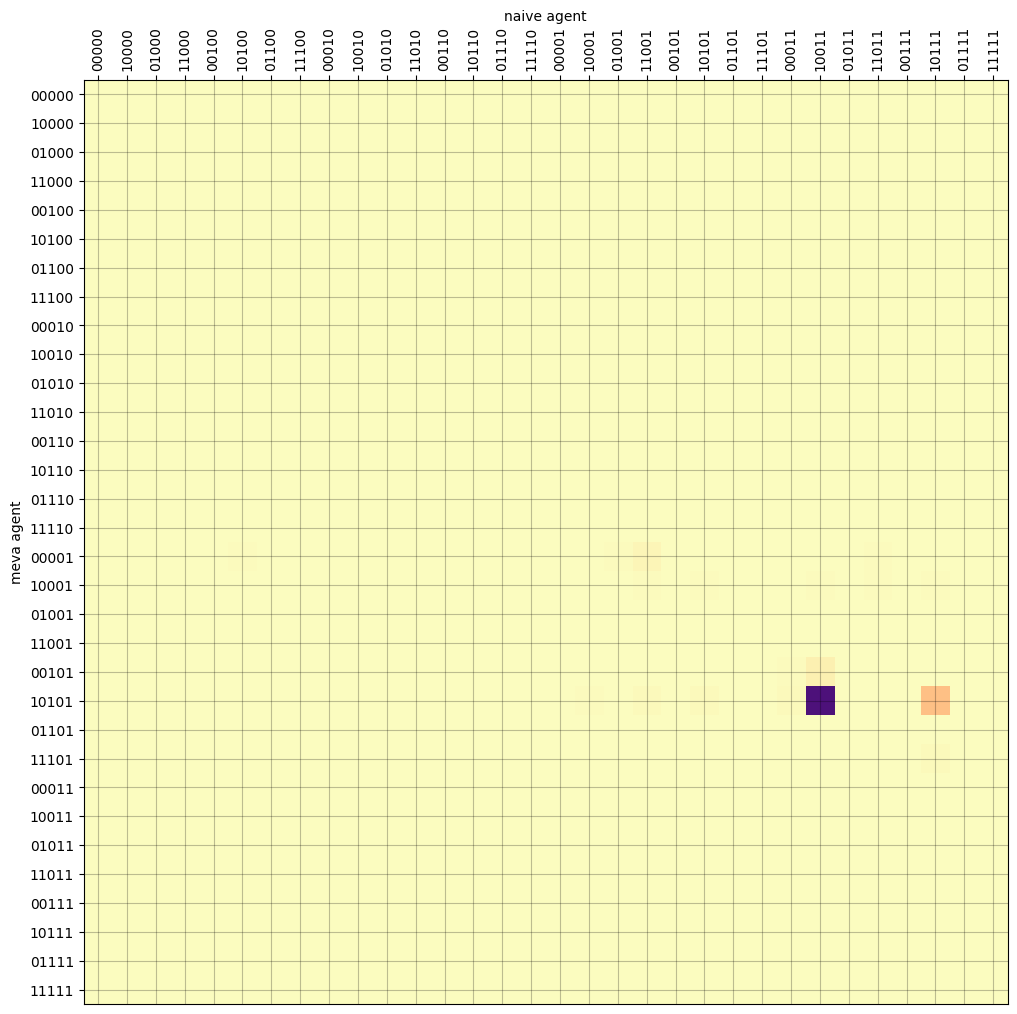

In [ ]:
# for example, to plot the histograms for seed 1, gamma 0.99:
plt.figure(figsize=(12,12))
plot_policy_histogram(Analysis.policies["99"]["agents"][1], plt.gca())
plt.ylabel("meva agent 1")
plt.xlabel("meva agent 2")
plt.figure(figsize=(12,12))
plot_policy_histogram(jp.stack([Analysis.policies["99"]["agents"][1,:,0],Analysis.policies["99"]["responses"][1,:,0]], axis=1), plt.gca())
plt.ylabel("meva agent")
plt.xlabel("best response")
plt.figure(figsize=(12,12))
plot_policy_histogram(Analysis.policies["99"]["shapings"][1], plt.gca())
plt.ylabel("meva agent")
plt.xlabel("naive agent")